# Задание на курсовой проект

Натренировать модель по данным из файла data/train.csv, и предсказать цену квартир, на данных из файла /data/test.csv. Рзультат предсказания сохранить в файл вида SShirkin_predictions.csv, который бы содержал поля: Id, Price и имел 5001 строку (шапка + 5000 квартир). Качество модели оценивается по rmse.

## Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import random
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse 
from sklearn.model_selection import KFold, GridSearchCV


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Добавим функцию оптимизации памяти

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

обработчик пропусков и выбросов

In [6]:
class Data:
    
    def __init__(self):
        """Задаем некоторые константы"""
        self.Square_min = 35
        self.Square_max = 380
        
        self.LifeSquare_min = 20
        self.LifeSquare_max = 320
        
        self.Rooms_min = 1
        self.Rooms_max = 19
        
        self.HouseFloor_min = 1
        self.HouseFloor_max = 35

        
        self.KitchenSquare_min = 3
        self.KitchenSquare_max = 30
        
        self.current_year = datetime.now().year
        
        self.medians = None
        self.DistrictId_value_counts = None
        self.SquareMeterPrice_by_DistrictId = None
        self.Healthcare_1_by_DistrictId = None
        
        
    def fit(self, train_df):
        
        # медианы
        self.medians = train_df[['LifeSquare', 'HouseFloor']].median()
        
        # подсчет популярных районов
        self.DistrictId_value_counts = dict(train_df['DistrictId'].value_counts())
        
        # подсчет средней цены за м2 по району
        train_df_temp = train_df.loc[((train_df['Square'] > self.Square_min) & (train_df['Square'] < self.Square_max))]
        train_df_temp["SquareMeterPrice"] = train_df_temp["Price"] / train_df_temp["Square"]
        self.SquareMeterPrice_by_DistrictId = train_df_temp.groupby('DistrictId', as_index=False)\
            .agg({'SquareMeterPrice': 'mean'})\
            .rename(columns={'SquareMeterPrice': 'AverageSquareMeterPrice'})
        
        # подсчет среднего значения признака Healthcare_1 по району
        self.Healthcare_1_by_DistrictId = train_df.groupby('DistrictId', as_index=False)\
            .agg({'Healthcare_1': 'mean'})\
            .rename(columns={'Healthcare_1': 'AverageHealthcare_1'})
        
        del train_df_temp
        
    def transform(self, train_df):
        
        # Обработка пропусков
        train_df[['LifeSquare', 'HouseFloor']] = train_df[['LifeSquare', 'HouseFloor']].fillna(self.medians)
        
        # Обработка выбросов
        
        # площадь
        train_df.loc[(train_df['Square'] > self.Square_max), 'Square'] = self.Square_max
        train_df.loc[(train_df['Square'] < self.Square_min), 'Square'] = self.Square_min
        
        # жилая площадь
        train_df.loc[(train_df['LifeSquare'] < self.LifeSquare_min), 'LifeSquare'] = self.LifeSquare_min
        train_df.loc[(train_df['LifeSquare'] > self.LifeSquare_max), 'LifeSquare'] = self.LifeSquare_max
        
        # площадь кухни
        train_df.loc[(train_df['KitchenSquare'] < self.KitchenSquare_min), 'KitchenSquare'] = self.KitchenSquare_min
        train_df.loc[(train_df['KitchenSquare'] > self.KitchenSquare_max), 'KitchenSquare'] = self.KitchenSquare_max
        
        # год постройки дома
        train_df.loc[(train_df['HouseYear'] > self.current_year), 'HouseYear'] = self.current_year
        
        # количество комнат
        train_df.loc[(train_df['Rooms'] > self.Rooms_max), 'Rooms'] = self.Rooms_max
        train_df.loc[(train_df['Rooms'] < self.Rooms_min), 'Rooms'] = self.Rooms_min
        
        # количество этажей
        train_df.loc[(train_df['HouseFloor'] < self.HouseFloor_min), 'HouseFloor'] = self.HouseFloor_min
        train_df.loc[(train_df['HouseFloor'] > self.HouseFloor_max), 'HouseFloor'] = self.HouseFloor_max
        
        # если этаж больше этажности дома, то присваиваем максимальный этаж
        floor_more = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
        train_df.loc[floor_more, 'Floor'] = train_df.loc[floor_more, 'HouseFloor']

        # если этаж меньше этажности дома, то присваиваем минимальный этаж
        floor_less = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
        train_df.loc[floor_less, 'Floor'] = train_df.loc[floor_less, 'HouseFloor']


        # Обработка категорий
        train_df = pd.concat([train_df, pd.get_dummies(train_df['Ecology_2'], prefix='Ecology_2', dtype='int8')], axis=1)
        train_df = pd.concat([train_df, pd.get_dummies(train_df['Ecology_3'], prefix='Ecology_3', dtype='int8')], axis=1)
        train_df = pd.concat([train_df, pd.get_dummies(train_df['Shops_2'], prefix='Shops_2', dtype='int8')], axis=1)
        
        return train_df
    
    def features(self, train_df):
        
        # добавление признака популярности района
        train_df['DistrictId_counts'] = train_df['DistrictId'].map(self.DistrictId_value_counts)
        train_df['DistrictId_counts'].fillna(train_df['DistrictId_counts'].median(), inplace=True)
        
        # добавление признака средней стоимости м2 по району
        train_df = train_df.merge(self.SquareMeterPrice_by_DistrictId, on=["DistrictId"], how='left')
        train_df['AverageSquareMeterPrice'].fillna(train_df['AverageSquareMeterPrice'].median(), inplace=True)
        
        # добавление признака среднего значения Healthcare_1 по району
        train_df = train_df.merge(self.Healthcare_1_by_DistrictId, on=["DistrictId"], how='left')
        train_df['AverageHealthcare_1'].fillna(train_df['AverageHealthcare_1'].median(), inplace=True)
        
        return train_df

## Подготовка данных

### загружаем данные

In [7]:
TRAIN_DATASET_PATH = 'data/train.csv'
TEST_DATASET_PATH = 'data/test.csv'

In [8]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [9]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


### получим информацию о данных для обучения

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

удалим колонку ID

In [11]:
train_df = train_df.drop('Id', axis =1 )

оптимизируем использование памяти

In [12]:
train_df  = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.45 MB
Memory usage after optimization is: 0.47 MB
Decreased by 67.7%


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   DistrictId     10000 non-null  int16   
 1   Rooms          10000 non-null  float32 
 2   Square         10000 non-null  float32 
 3   LifeSquare     7887 non-null   float32 
 4   KitchenSquare  10000 non-null  float32 
 5   Floor          10000 non-null  int8    
 6   HouseFloor     10000 non-null  float32 
 7   HouseYear      10000 non-null  int32   
 8   Ecology_1      10000 non-null  float32 
 9   Ecology_2      10000 non-null  category
 10  Ecology_3      10000 non-null  category
 11  Social_1       10000 non-null  int8    
 12  Social_2       10000 non-null  int16   
 13  Social_3       10000 non-null  int16   
 14  Healthcare_1   5202 non-null   float32 
 15  Helthcare_2    10000 non-null  int8    
 16  Shops_1        10000 non-null  int8    
 17  Shops_2        10000 non-null  c

разделим признаки на числовые и категориальные

In [14]:
num_feat = list(train_df.select_dtypes(exclude='category').columns)
num_feat

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price']

In [15]:
obj_feat = list(train_df.select_dtypes(include='category').columns)
obj_feat

['Ecology_2', 'Ecology_3', 'Shops_2']

### Взглянем на данные

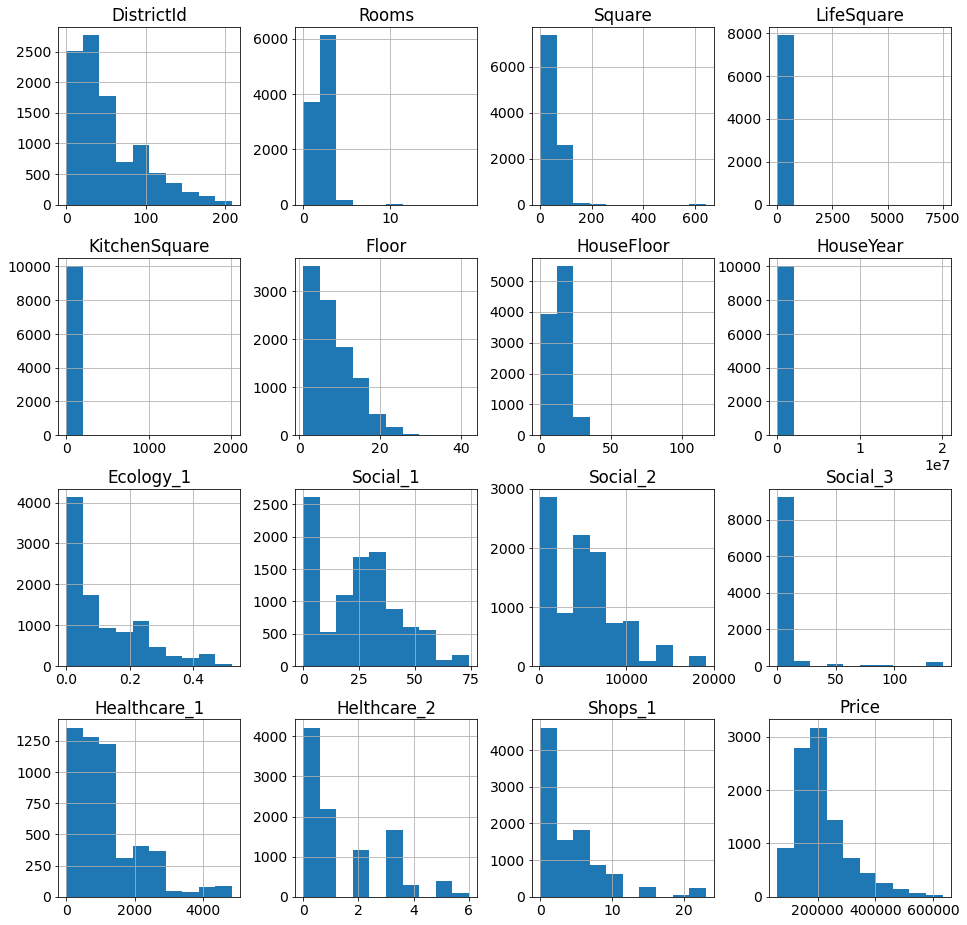

In [16]:
train_df[num_feat].hist(
    figsize=(16,16)
)
plt.show()

## зависимость цены от признаков

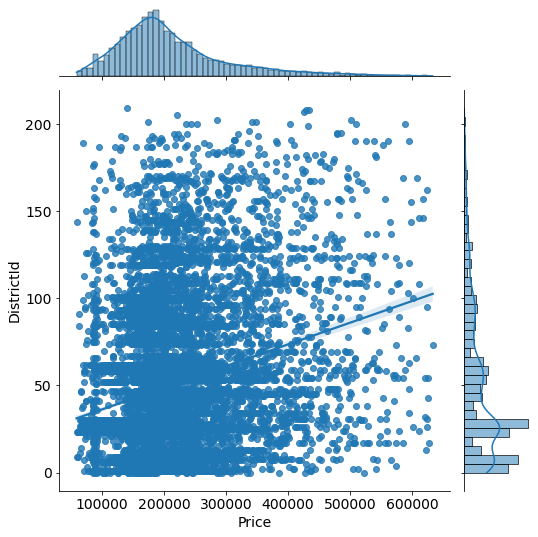

In [17]:
grid = sns.jointplot(train_df['Price'], train_df['DistrictId'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

При анализе графиков отношения Цены на квартиру к признакам, было выявлено, что наибольшее влияние на цену оказывают: DistrictId (район), Floor (этаж квартиры), Square (общая площадь), Ecology_1 (имеет обратную зависимость), Social_1 (при чем Social_1 и Social_2 корелируют друг с другом), Social_3, Helthcare_2 (при чем Healthcare_1 и Helthcare_2 так же корелируют друг с другом, но у Helthcare_2 меньше выбросов) и Shops_1.

Именно их и будем использовать для обучения модели.




### не много графиков (закоментированы)

In [18]:
# grid = sns.jointplot(train_df['Price'], train_df['Floor'], kind='reg')
# grid.fig.set_figwidth(8)
# grid.fig.set_figheight(8)

# plt.show()

In [19]:
# grid = sns.jointplot(train_df['Price'], train_df['Square'], kind='reg')
# grid.fig.set_figwidth(8)
# grid.fig.set_figheight(8)

# plt.show()

In [20]:
# grid = sns.jointplot(train_df['Price'], train_df['Ecology_1'], kind='reg')
# grid.fig.set_figwidth(8)
# grid.fig.set_figheight(8)

# plt.show()

In [21]:
# grid = sns.jointplot(train_df['Price'], train_df['Social_1'], kind='reg')
# grid.fig.set_figwidth(8)
# grid.fig.set_figheight(8)

# plt.show()

In [22]:
# grid = sns.jointplot(train_df['Price'], train_df['Social_3'], kind='reg')
# grid.fig.set_figwidth(8)
# grid.fig.set_figheight(8)

# plt.show()

In [23]:
# grid = sns.jointplot(train_df['Price'], train_df['Helthcare_2'], kind='reg')
# grid.fig.set_figwidth(8)
# grid.fig.set_figheight(8)

# plt.show()

In [24]:
# grid = sns.jointplot(train_df['Price'], train_df['Shops_1'], kind='reg')
# grid.fig.set_figwidth(8)
# grid.fig.set_figheight(8)

# plt.show()

## Обработаем пропуски и выбросы в данных

In [25]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315777,37.199646,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.859375
std,43.587592,0.839512,21.058731,86.241211,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517273,1.493601,4.806341,92872.289062
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [26]:
data_inst = Data()

# тренировочные данные
data_inst.fit(train_df)
train_df = data_inst.transform(train_df)
train_df = data_inst.features(train_df)

# тестовые данные
test_df = data_inst.transform(test_df)
test_df = data_inst.features(test_df)

In [27]:
num_feat = list(train_df.select_dtypes(exclude='category').columns)
num_feat 

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B',
 'DistrictId_counts',
 'AverageSquareMeterPrice',
 'AverageHealthcare_1']

In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   DistrictId               10000 non-null  int16   
 1   Rooms                    10000 non-null  float32 
 2   Square                   10000 non-null  float32 
 3   LifeSquare               10000 non-null  float32 
 4   KitchenSquare            10000 non-null  float32 
 5   Floor                    10000 non-null  float32 
 6   HouseFloor               10000 non-null  float32 
 7   HouseYear                10000 non-null  int32   
 8   Ecology_1                10000 non-null  float32 
 9   Ecology_2                10000 non-null  category
 10  Ecology_3                10000 non-null  category
 11  Social_1                 10000 non-null  int8    
 12  Social_2                 10000 non-null  int16   
 13  Social_3                 10000 non-null  int16   
 14  Healthc

# Тренировка модели

In [29]:
feat = ['DistrictId',
          'Rooms',
          'Square',
          'LifeSquare',
          'KitchenSquare',
          'Floor',
          'HouseFloor',
          'HouseYear',
          'Ecology_1',
          'Social_1',
          'Social_2',
          'Social_3',
          'Helthcare_2',
          'Shops_1',
          'Ecology_2_A',
          'Ecology_2_B',
          'Ecology_3_A',
          'Ecology_3_B',
          'Shops_2_A',
          'Shops_2_B',
          'DistrictId_counts',
          'AverageSquareMeterPrice',
          'AverageHealthcare_1'
          ]
x = train_df[feat]
y = train_df['Price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [30]:
forest = RandomForestRegressor()
forest.fit(x_train, y_train)

RandomForestRegressor()

Train R2:	0.963
Test R2:	0.769


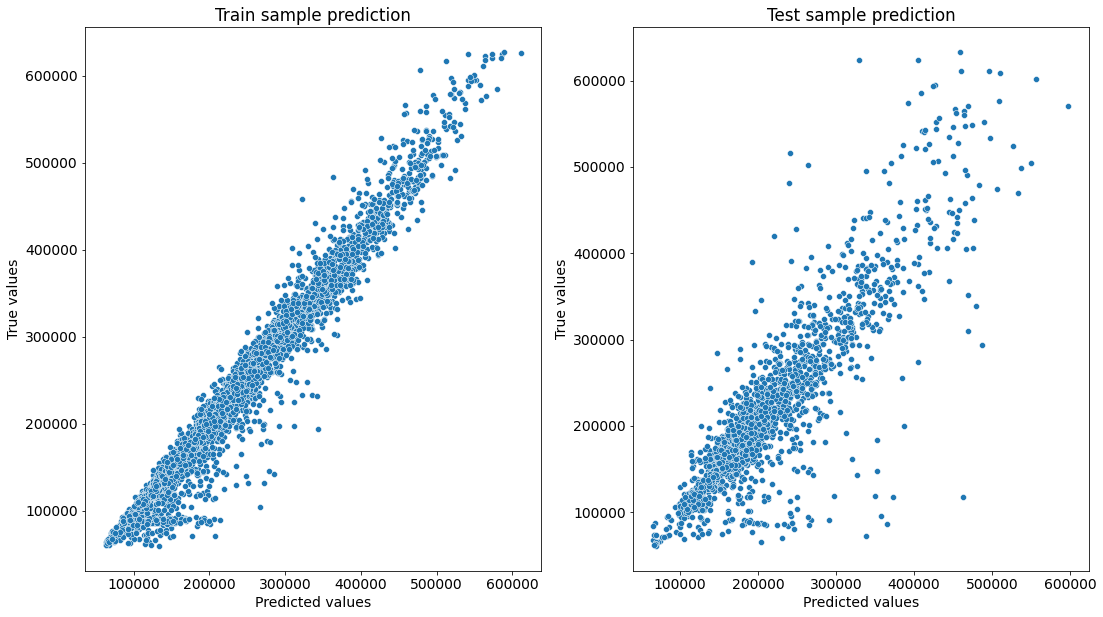

In [31]:
train_pred = forest.predict(x_train)
test_pred = forest.predict(x_test)
evaluate_preds(y_train, train_pred, y_test, test_pred)

In [32]:
forest = RandomForestRegressor()
forest.fit(x, y)

RandomForestRegressor()

In [33]:
itog_test = test_df[feat]
itog_test = itog_test.fillna(0)
pred = pd.DataFrame(forest.predict(itog_test))
pred.head()

,0
0,151093.567344
1,110818.871719
2,137690.924297
3,142933.076094
4,170543.812344


In [34]:
pr = pd.read_csv('data/sample_submission.csv')
pr.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [35]:
pr['Price'] = pred
pr.head()

,Id,Price
0,4567,151093.567344
1,5925,110818.871719
2,960,137690.924297
3,3848,142933.076094
4,746,170543.812344


In [36]:
pr.shape

(5000, 2)

In [37]:
pr.to_csv('VKrasnov_predict.csv', index=False)